# Boston Housing Regression

## Overview
1. Import Libraries
2. Load Data
3. Data Analysis
4. Model Classes
5. Training and Testing
6. Evaluation
7. Model Comparison
8. Conclusion



<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Pytorch-lightning</center></span>

<center>Introducción</center>

<figure>
<center>
<img src="../Imagenes/trainer.png" width="800" height="800" align="center"/>
</center>
</figure>


Fuente: Alvaro Montenegro

##   <span style="color:blue">Profesores</span>

### Coordinador

- Campo Elías Pardo, PhD, cepardot@unal.edu.co

### Conferencistas

- Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
- Daniel  Montenegro, Msc, dextronomo@gmail.com 
- Oleg Jarma, Estadístico, ojarmam@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

- Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

- Nayibe Yesenia Arias, naariasc@unal.edu.co
- Venus Celeste Puertas, vpuertasg@unal.edu.co 

## <span style="color:blue">Referencias</span>

1. [Alvaro Montenegro y Daniel Montenegro, Inteligencia Artificial y Aprendizaje Profundo, 2021](https://github.com/AprendizajeProfundo/Diplomado)
1. [Alvaro Montenegro, Daniel Montenegro y Oleg Jarma, Inteligencia Artificial y Aprendizaje Profundo Avanzado, 2022](https://github.com/AprendizajeProfundo/Diplomado-Avanzado)
1. [Tutoriales de Pytorch](https://pytorch.org/tutorials/)
1. [Pytorchlightning.ai](https://www.pytorchlightning.ai/)

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Instalar Pytorch-lightning](#Instalar-Pytorch-lightning)
* [Ejemplo de un módulo Lightning](#Ejemplo-de-un-módulo-Lightning)

## <span style="color:blue">Introducción</span> 

# Import Libaries

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch import optim
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [ ]:
boston = datasets.load_boston()
X, y = boston.data, boston.target
X = X.astype(np.float32)
y = y.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
n_samples, n_features = X.shape
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

# Data Analysis

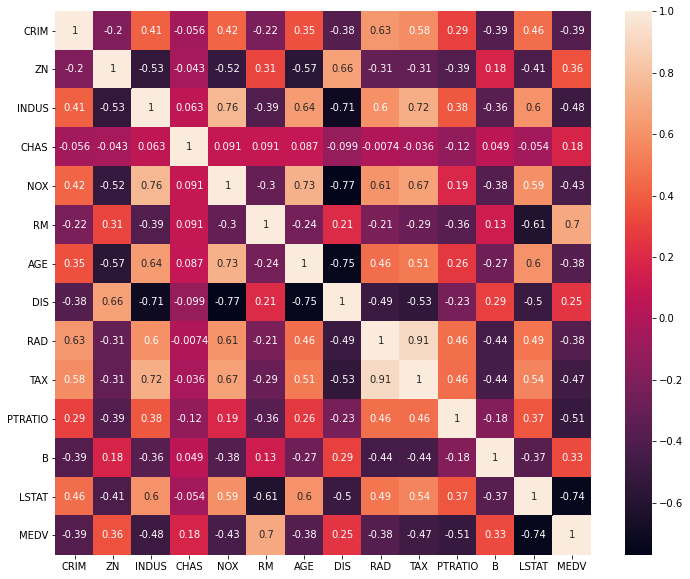

In [ ]:
cols = list(boston.feature_names) + ['MEDV']
boston_df = pd.DataFrame(np.hstack([X, np.atleast_2d(y).T]), columns=cols)
plt.figure(figsize=(12,10))
sns.heatmap(boston_df.corr(), annot=True)
# print(X.shape, np.atleast_2d(y).T.shape)

We will be predicting **MEDV**. 

From the above Correlation table, we see that there are pretty significant negative correlations between LSTAT, PTRATIO, INDUS, and TAX and MEDV. There is one significant positive correlation between RM and MEDV. The rest of the variables are correlated but much less significantly.

# Model Classes

## Data Class

In [ ]:
class DataMaker(Data.Dataset):
    def __init__(self, X, y):
        # scaler = StandardScaler()
        scaler = MinMaxScaler()
        self.targets = scaler.fit_transform(X.astype(np.float32))
        self.labels = y.astype(np.float32)
    
    def __getitem__(self, i):
        return self.targets[i, :], self.labels[i]

    def __len__(self):
        return len(self.targets)

## Neural Network Class

In [ ]:
class Model(nn.Module):
    def __init__(self, n_features, hiddenA, hiddenB):
        super(Model, self).__init__()
        self.linearA = nn.Linear(n_features, hiddenA)
        self.linearB = nn.Linear(hiddenA, hiddenB)
        self.linearC = nn.Linear(hiddenB, 1)

    def forward(self, x):
        yA = F.relu(self.linearA(x))
        yB = F.relu(self.linearB(yA))
        return self.linearC(yB)

In [ ]:
torch.manual_seed(1)

In [ ]:
train_set = DataMaker(X_train, y_train)
test_set = DataMaker(X_test, y_test)

In [ ]:
bs = 25
train_loader = Data.DataLoader(train_set, batch_size=bs, shuffle=True)
test_loader = Data.DataLoader(test_set, batch_size=bs, shuffle=True)

In [ ]:
net = Model(n_features, 100, 50)

In [ ]:
criterion = nn.MSELoss(size_average=False)
optimizer = optim.Adam(net.parameters(), lr=0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Training and Testing

## Training

In [ ]:
n_epochs = 200
all_losses = []
for epoch in range(n_epochs):
    progress_bar = tqdm.notebook.tqdm(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        optimizer.zero_grad()
        y_pred = net(inputs)
        loss = criterion(y_pred, torch.unsqueeze(target,dim=1))

        loss.backward()
        
        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1

    epoch_loss = sum(losses) / total
    all_losses.append(epoch_loss)
                
    mess = f"Epoch #{epoch+1}\tLoss: {all_losses[-1]:.3f}"
    tqdm.tqdm.write(mess)

Epoch #1	Loss: 8438.962


Epoch #2	Loss: 3305.272


Epoch #3	Loss: 1451.997


Epoch #4	Loss: 1179.075


Epoch #5	Loss: 1077.644


Epoch #6	Loss: 911.273


Epoch #7	Loss: 823.515


Epoch #8	Loss: 664.849


Epoch #9	Loss: 591.992


Epoch #10	Loss: 570.358


Epoch #11	Loss: 512.213


Epoch #12	Loss: 534.148


Epoch #13	Loss: 493.230


Epoch #14	Loss: 471.833


Epoch #15	Loss: 471.837


Epoch #16	Loss: 456.186


Epoch #17	Loss: 436.200


Epoch #18	Loss: 437.576


Epoch #19	Loss: 411.811


Epoch #20	Loss: 454.263


Epoch #21	Loss: 417.543


Epoch #22	Loss: 495.573


Epoch #23	Loss: 408.144


Epoch #24	Loss: 394.152


Epoch #25	Loss: 386.870


Epoch #26	Loss: 377.577


Epoch #27	Loss: 363.463


Epoch #28	Loss: 355.211


Epoch #29	Loss: 390.887


Epoch #30	Loss: 391.939


Epoch #31	Loss: 357.605


Epoch #32	Loss: 332.126


Epoch #33	Loss: 328.227


Epoch #34	Loss: 325.852


Epoch #35	Loss: 320.145


Epoch #36	Loss: 340.561


Epoch #37	Loss: 335.360


Epoch #38	Loss: 304.258


Epoch #39	Loss: 320.767


Epoch #40	Loss: 314.455


Epoch #41	Loss: 294.160


Epoch #42	Loss: 293.333


Epoch #43	Loss: 283.039


Epoch #44	Loss: 291.830


Epoch #45	Loss: 398.876


Epoch #46	Loss: 336.264


Epoch #47	Loss: 302.031


Epoch #48	Loss: 249.705


Epoch #49	Loss: 264.481


Epoch #50	Loss: 254.465


Epoch #51	Loss: 370.406


Epoch #52	Loss: 254.825


Epoch #53	Loss: 235.209


Epoch #54	Loss: 242.049


Epoch #55	Loss: 247.911


Epoch #56	Loss: 254.308


Epoch #57	Loss: 238.928


Epoch #58	Loss: 275.136


Epoch #59	Loss: 218.326


Epoch #60	Loss: 226.807


Epoch #61	Loss: 208.098


Epoch #62	Loss: 209.842


Epoch #63	Loss: 227.085


Epoch #64	Loss: 224.350


Epoch #65	Loss: 209.866


Epoch #66	Loss: 198.802


Epoch #67	Loss: 239.447


Epoch #68	Loss: 231.801


Epoch #69	Loss: 213.230


Epoch #70	Loss: 200.897


Epoch #71	Loss: 195.198


Epoch #72	Loss: 213.359


Epoch #73	Loss: 179.361


Epoch #74	Loss: 176.474


Epoch #75	Loss: 182.007


Epoch #76	Loss: 201.111


Epoch #77	Loss: 188.151


Epoch #78	Loss: 206.076


Epoch #79	Loss: 195.297


Epoch #80	Loss: 173.018


Epoch #81	Loss: 176.531


Epoch #82	Loss: 181.873


Epoch #83	Loss: 173.484


Epoch #84	Loss: 169.319


Epoch #85	Loss: 175.202


Epoch #86	Loss: 171.606


Epoch #87	Loss: 172.742


Epoch #88	Loss: 173.527


Epoch #89	Loss: 185.337


Epoch #90	Loss: 163.589


Epoch #91	Loss: 163.818


Epoch #92	Loss: 184.905


Epoch #93	Loss: 163.878


Epoch #94	Loss: 157.830


Epoch #95	Loss: 181.978


Epoch #96	Loss: 168.565


Epoch #97	Loss: 181.846


Epoch #98	Loss: 190.876


Epoch #99	Loss: 207.938


Epoch #100	Loss: 194.220


Epoch #101	Loss: 156.317


Epoch #102	Loss: 161.641


Epoch #103	Loss: 179.921


Epoch #104	Loss: 174.595


Epoch #105	Loss: 163.848


Epoch #106	Loss: 149.826


Epoch #107	Loss: 143.971


Epoch #108	Loss: 161.959


Epoch #109	Loss: 143.979


Epoch #110	Loss: 163.890


Epoch #111	Loss: 167.068


Epoch #112	Loss: 140.713


Epoch #113	Loss: 146.989


Epoch #114	Loss: 159.036


Epoch #115	Loss: 134.057


Epoch #116	Loss: 144.638


Epoch #117	Loss: 139.355


Epoch #118	Loss: 134.582


Epoch #119	Loss: 134.967


Epoch #120	Loss: 141.251


Epoch #121	Loss: 146.727


Epoch #122	Loss: 138.727


Epoch #123	Loss: 130.143


Epoch #124	Loss: 121.959


Epoch #125	Loss: 127.612


Epoch #126	Loss: 139.520


Epoch #127	Loss: 148.662


Epoch #128	Loss: 125.628


Epoch #129	Loss: 131.352


Epoch #130	Loss: 124.044


Epoch #131	Loss: 144.522


Epoch #132	Loss: 127.711


Epoch #133	Loss: 130.017


Epoch #134	Loss: 126.758


Epoch #135	Loss: 133.326


Epoch #136	Loss: 151.529


Epoch #137	Loss: 140.812


Epoch #138	Loss: 138.775


Epoch #139	Loss: 132.152


Epoch #140	Loss: 133.083


Epoch #141	Loss: 118.037


Epoch #142	Loss: 130.651


Epoch #143	Loss: 147.185


Epoch #144	Loss: 136.402


Epoch #145	Loss: 138.362


Epoch #146	Loss: 112.916


Epoch #147	Loss: 114.177


Epoch #148	Loss: 121.326


Epoch #149	Loss: 135.351


Epoch #150	Loss: 106.837


Epoch #151	Loss: 120.128


Epoch #152	Loss: 114.404


Epoch #153	Loss: 119.742


Epoch #154	Loss: 118.359


Epoch #155	Loss: 115.176


Epoch #156	Loss: 120.511


Epoch #157	Loss: 110.632


Epoch #158	Loss: 118.566


Epoch #159	Loss: 126.523


Epoch #160	Loss: 118.074


Epoch #161	Loss: 110.693


Epoch #162	Loss: 114.219


Epoch #163	Loss: 124.370


Epoch #164	Loss: 164.796


Epoch #165	Loss: 110.554


Epoch #166	Loss: 107.709


Epoch #167	Loss: 110.062


Epoch #168	Loss: 112.563


Epoch #169	Loss: 120.224


Epoch #170	Loss: 107.382


Epoch #171	Loss: 117.475


Epoch #172	Loss: 101.432


Epoch #173	Loss: 98.448


Epoch #174	Loss: 96.894


Epoch #175	Loss: 113.659


Epoch #176	Loss: 109.033


Epoch #177	Loss: 93.390


Epoch #178	Loss: 101.454


Epoch #179	Loss: 111.230


Epoch #180	Loss: 112.856


Epoch #181	Loss: 104.781


Epoch #182	Loss: 112.148


Epoch #183	Loss: 111.531


Epoch #184	Loss: 101.490


Epoch #185	Loss: 121.058


Epoch #186	Loss: 109.684


Epoch #187	Loss: 106.667


Epoch #188	Loss: 90.524


Epoch #189	Loss: 99.213


Epoch #190	Loss: 102.562


Epoch #191	Loss: 108.605


Epoch #192	Loss: 100.895


Epoch #193	Loss: 109.616


Epoch #194	Loss: 104.065


Epoch #195	Loss: 94.181


Epoch #196	Loss: 93.193


Epoch #197	Loss: 96.836


Epoch #198	Loss: 119.582


Epoch #199	Loss: 134.176


Epoch #200	Loss: 102.497


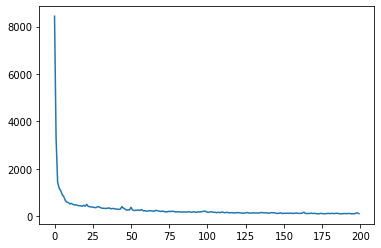

In [ ]:
plt.plot(all_losses)

## Testing

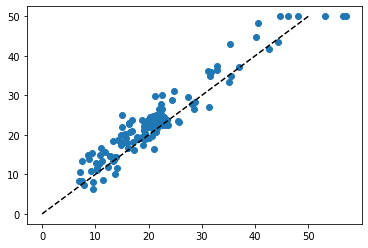

In [ ]:
y_pred = []
y_true = []
net.train(False)
for inputs, targets in test_loader:
    y_pred.extend(net(inputs).data.numpy())
    y_true.extend(targets.numpy())
plt.scatter(y_pred, y_true)
plt.plot([0, 50], [0, 50], '--k')

In [ ]:
print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))
print("R^2:", r2_score(y_true, y_pred))

MAE: 2.8533225
MSE: 12.865284
R^2: 0.8701243400257248


# Model Comparison

This model was used as an example in an Sklearn Demo titled: [Effect of transforming the targets in regression model](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py).

MAE: 3.1484922112754266
MSE: 20.011873172980735
R^2: 0.7979791908673539


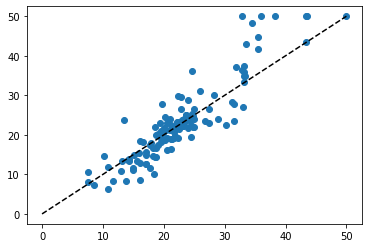

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import QuantileTransformer

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(
        n_quantiles=300, output_distribution='normal'))

regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)
plt.scatter(y_pred, y_test)
plt.plot([0, 50], [0, 50], '--k')
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

# Conclusion

We can make an incomplete conclusion that the pytorch model is a better predictor than this Transformed Target Ridge Regression model, with built-in Cross validation.

This does not mean that Neural Networks are the best way to solve regression problems, or this problem.

In order to claim that, we would have to compare many different ML models, and also perform tuning the Neural Network's hyperparameters.